In [24]:
import os
import SimpleITK
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [25]:
def sitk_show(img, title=None, margin=0.05, dpi=40):
    nda = SimpleITK.GetArrayFromImage(img)
    spacing = img.GetSpacing()
    figsize = (1 + margin) * nda.shape[0] / dpi, (1 + margin) * nda.shape[1] / dpi
    extent = (0, nda.shape[1]*spacing[1], nda.shape[0]*spacing[0], 0)
    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])

    plt.set_cmap("gray")
    ax.imshow(nda,extent=extent,interpolation=None)
    
    if title:
        plt.title(title)
    
    plt.show()

In [26]:
# Directory where the DICOM files are being stored (in this
# case the 'MyHead' folder). 
pathDicom = "/Volumes/homes/users/anthony.reina/dicom/Head CT/MyHead/"

In [27]:
# Z slice of the DICOM files to process. In the interest of
# simplicity, segmentation will be limited to a single 2D
# image but all processes are entirely applicable to the 3D image
idxSlice = 50

# int labels to assign to the segmented white and gray matter.
# These need to be different integers but their values themselves
# don't matter
labelWhiteMatter = 1
labelGrayMatter = 2

## Here's where we read in the DICOM images as a set

In [28]:
reader = SimpleITK.ImageSeriesReader()
filenamesDICOM = reader.GetGDCMSeriesFileNames(pathDicom)
reader.SetFileNames(filenamesDICOM)
imgOriginal = reader.Execute()

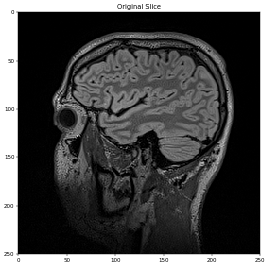

In [29]:
imgOriginal = imgOriginal[:,:,idxSlice]

sitk_show(imgOriginal, 'Original Slice')


In [30]:
imgSmooth = SimpleITK.CurvatureFlow(image1=imgOriginal,
                                    timeStep=0.125,
                                    numberOfIterations=5)

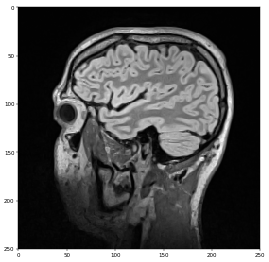

In [31]:
# blurFilter = SimpleITK.CurvatureFlowImageFilter()
# blurFilter.SetNumberOfIterations(5)
# blurFilter.SetTimeStep(0.125)
# imgSmooth = blurFilter.Execute(imgOriginal)

sitk_show(imgSmooth)

lstSeeds = [(150,75)]

In [32]:
imgWhiteMatter = SimpleITK.ConfidenceConnected(image1=imgSmooth, 
                                               seedList=lstSeeds,
                                               numberOfIterations=5,
                                               multiplier=3,
                                               replaceValue=labelWhiteMatter)

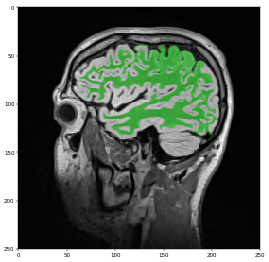

In [33]:
imgSmoothInt = SimpleITK.Cast(SimpleITK.RescaleIntensity(imgSmooth), imgWhiteMatter.GetPixelID())

sitk_show(SimpleITK.LabelOverlay(imgSmoothInt, imgWhiteMatter))

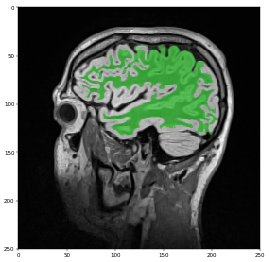

In [34]:
imgWhiteMatterNoHoles = SimpleITK.BinaryClosingByReconstruction(imgWhiteMatter, 100)

sitk_show(SimpleITK.LabelOverlay(imgSmoothInt, imgWhiteMatterNoHoles))

lstSeeds = [(119, 83), (198, 80), (100,100), (185, 102), (164, 43)]

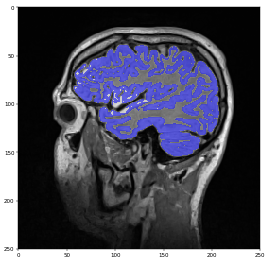

In [35]:
imgGrayMatter = SimpleITK.ConfidenceConnected(image1=imgSmooth, 
                                              seedList=lstSeeds,
                                              numberOfIterations=3,
                                              multiplier=1.75,
                                              replaceValue=labelGrayMatter)

sitk_show(SimpleITK.LabelOverlay(imgSmoothInt, imgGrayMatter))

imgLabels = imgWhiteMatterNoHoles | imgGrayMatter

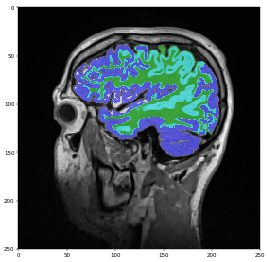

In [36]:
sitk_show(SimpleITK.LabelOverlay(imgSmoothInt, imgLabels))

imgMask= imgWhiteMatterNoHoles/labelWhiteMatter * imgGrayMatter/labelGrayMatter
imgWhiteMatterNoHoles -= imgMask*labelWhiteMatter

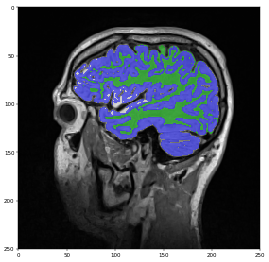

In [37]:
imgLabels = imgWhiteMatterNoHoles + imgGrayMatter

sitk_show(SimpleITK.LabelOverlay(imgSmoothInt, imgLabels))